Clasificador de Imágenes - Grupo 43 - Gabriel Dominguez Torres y Meng Fei Dai

1- Detectamos el dispositivo para que automaticamente use el CPU o el GPU de nuestro ordenador.

In [1]:
import torch
# Detectar el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


2- Importamos el dataset, en este caso es un dataset de paisajes.

In [2]:
# Importamos el dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

3- Definimos las transformaciones para normalizar los datos. Cargamos el dataset y le definimos un batch de 64 (unidades de cada paquete) y finalmente mostramos las clases para ver cuantas hay.

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((150, 150)), #redimensionamos las imagenes a 150x150 como nos indica el dataset
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar dataset
train_data = datasets.ImageFolder(root=f"{path}/seg_train/seg_train", transform=transform)
test_data = datasets.ImageFolder(root=f"{path}/seg_test/seg_test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Mostrar clases
print(f"Clases encontradas: {train_data.classes}")

Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


4- Obtenemos una imagen del dataset aleatoriamente y la mostramos por pantalla.

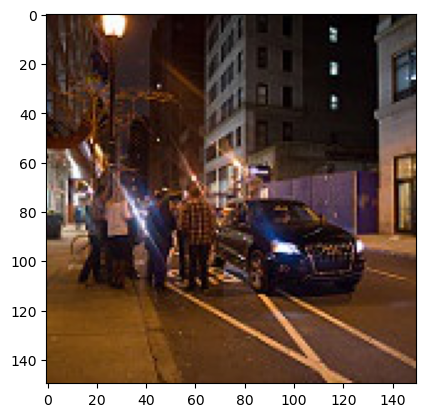

In [4]:
# Vamos a visualizar una imagen del dataset
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos una imagen del dataset
i = np.random.randint(len(train_data))
image, label = train_data[i]
image = image.unsqueeze(0).to(device)   #desnormalizamos

plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.show()

5- Creamos el modelo donde tenemos un 2 redes convolutivas, en medio 2 Max Pooling y 2 lineales al final

In [5]:
import torch.nn as nn
import torch.nn.functional as F

#5. Definimos el modelo
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 3 canales, Salida: 32 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # Entrada: 32 canales, Salida: 64 canales
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.fc1 = nn.Linear(64 * 37 * 37, 128)  # Imágenes reducidas a 150x150 después del pooling
        self.fc2 = nn.Linear(128, 6)  # 6 clases de salida para MNIST
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 37 * 37)  # Aplanar
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ConvNet().to(device)
print(model)
print("Número de parámetros:", sum(p.numel() for p in model.parameters()))

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Número de parámetros: 11269446


6- Creamos una predicción antes del entrenamiento para más tarde comprobar su buen entrenamiento.

In [6]:
# Predicción antes del entrenamiento
model.eval()
with torch.no_grad():
    output = model(image)  # Agregar dimensión batch
    _, pred = torch.max(output, 1)  # Índice de la mayor probabilidad

# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")

Etiqueta real: street
Predicción del modelo: mountain


7- Definimos el criterio de pérdida y el optimizador

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

8- Empezamos el entrenamiento donde le definimos 15 épocas.

In [8]:
# Entrenamiento
epochs = 15
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 1.0315914266488768
Epoch 2, Loss: 0.6829380715435202
Epoch 3, Loss: 0.5463803541931239
Epoch 4, Loss: 0.43624812676147984
Epoch 5, Loss: 0.35329356958920305
Epoch 6, Loss: 0.24684851630167529
Epoch 7, Loss: 0.1849899841641838
Epoch 8, Loss: 0.11267555241727016
Epoch 9, Loss: 0.07790757899426601
Epoch 10, Loss: 0.05277313949455592
Epoch 11, Loss: 0.03675413756758313
Epoch 12, Loss: 0.03033466904572296
Epoch 13, Loss: 0.04215579748058438
Epoch 14, Loss: 0.057449670041784306
Epoch 15, Loss: 0.04400409868050536


9- Empezamos la evaluación para comprobar si se ha entrenado bien nuestro modelo. 

In [9]:
# Evaluación
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) #obtenemos las imagenes y los labels
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #predicción despues del entrenamiento
        output = model(image)  # Agregar dimensión batch
        _,pred = torch.max(output, 1)  # Índice de la mayor probabilidad

print(f'Accuracy of the model on the test images: {100 * correct / total}%')
# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")

Accuracy of the model on the test images: 76.1%
Etiqueta real: street
Predicción del modelo: street
